<a href="https://colab.research.google.com/github/DRWang3/MPM_testing/blob/main/skeleton_drw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [550]:
#@title Model handler class
#from IPython.display import display, HTML
#display(HTML('<h1 style="color: blue; background-color: lightyellow; padding: 10px; border-radius: 5px;">Custom Header</h1>'))

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

class model_handler:
    """Model Handler class for taking in input files and running the simulation.

    Attributes:
        drivers_filename (str): Path to the drivers CSV file.
        parameter_filename (str): Path to the parameters CSV file.
    """

    def __init__(self, drivers_filename, parameter_filename, resource_pool_filename):
        self.drivers_filename = drivers_filename
        self.parameter_filename = parameter_filename
        self.resource_pool_filename = resource_pool_filename
        self.log_thermal_age = []
        self.log_assimilation = []

    def read_input_files(self):
        # Read input CSV files for drivers and parameters
        drivers = pd.read_csv(self.drivers_filename)
        params = pd.read_csv(self.parameter_filename, header=None)
        params_dict = params.set_index(0).to_dict()[1]
        resource_pools = pd.read_csv(self.resource_pool_filename)
        resource_pools = resource_pools.to_dict(orient='records')
        return drivers, params_dict, resource_pools

    def plot_outputs(self):

        log_assimilation = self.log_assimilation
        #log_thermal_age = self.log_thermal_age

        # Plotting log_assimilation (y-axis) against log_thermal_age (x-axis)
        plt.plot(list(range(len(log_assimilation))), log_assimilation, marker='o', linestyle='-')
        plt.xlabel('Time Step')
        plt.ylabel('Assimilation')
        plt.grid(True)
        plt.show()


    def run_simulation(self):
        # Run simulation by looping through each timestep
        drivers, params_dict, resource_pools = self.read_input_files()

        # Make a plant object
        plant_simulated = plant(params_dict, resource_pools)

        for index, row in drivers.iterrows():
            DOY = row['DOY']
            latitude = row['latitude']
            hour = row['Hour']

            # atmosphere object for computing atmospheric properties at this timestep
            atmosphere_instance = atmosphere(DOY, latitude, hour)
            atmosphere_instance.compute_atmospheric_properties()

            # put together a collective exogenous inputs dict
            exogenous_inputs = atmosphere_instance.get_atmospheric_properties()
            driver_entries = {
              'temperature': row['temperature'],
              'radiation': row['radiation'],
              'precipitation': row['precipitation'],
              'wind_speed': row['wind_speed'],
              'VPD': row['VPD'],
              'latitude': row['latitude']
            }
            exogenous_inputs.update(driver_entries)

            # environment object that acts as interface between plant and non-plant - just aboveground environment for now
            aboveground_environment_instance = aboveground_environment(exogenous_inputs)
            aboveground_environment_instance.compute_canopy_light_environment()

            # one simulation step of plant
            plant_simulated.simulate_plant(aboveground_environment_instance.get_exogenous_inputs(), aboveground_environment_instance.get_aboveground_variables())

            self.log_assimilation.append(plant_simulated.get_assimilation_sunlit())
            self.log_thermal_age.append(plant_simulated.get_thermal_age())


In [551]:
#@title Atmosphere class
class atmosphere:
    """This class calculates atmospheric properties for a model timestep
    """

    def __init__(self, DOY, latitude, hour):
        self.rad = np.pi / 180
        self.lat = latitude
        self.doy = DOY
        self.hour = hour

    def compute_atmospheric_properties(self):
        #computes atmospheric properties needed for simulating under field conditions

        Sun_Angle_Inclination = -2
        dec = np.arcsin(np.sin(23.45 * self.rad) * np.cos(2 * np.pi * (self.doy + 10) / 365))
        Sin_Solar_Declination = np.sin(self.rad * self.lat) * np.sin(dec)
        Cos_Solar_Declination = np.cos(self.rad * self.lat) * np.cos(dec)
        angle_factor = Sin_Solar_Declination / Cos_Solar_Declination

        Day_Length = 12.0 * (1 + 2 * np.arcsin(angle_factor) / np.pi)
        Photoperiod_Day_Length = 12.0 * (1 + 2 * np.arcsin((-np.sin(Sun_Angle_Inclination * self.rad) + Sin_Solar_Declination) / Cos_Solar_Declination) / np.pi)
        Daily_Sin_Beam_Exposure = 3600 * (Day_Length * (Sin_Solar_Declination + 0.4 * (Sin_Solar_Declination**2 + Cos_Solar_Declination**2 * 0.5)) +
                             12.0 * Cos_Solar_Declination * (2.0 + 3.0 * 0.4 * Sin_Solar_Declination) * np.sqrt(1.0 - angle_factor**2) / np.pi)
        Solar_Constant = 1367 * (1 + 0.033 * np.cos(2 * np.pi * (self.doy - 10) / 365))

        hour_angle = (self.hour - 12) * 15 * self.rad
        Sin_Beam = max(1e-32, Sin_Solar_Declination * np.sin(hour_angle) + Cos_Solar_Declination * np.cos(hour_angle))

        self.atmospheric_properties_dict = {
            'Solar_Constant': Solar_Constant,
            'Sin_Solar_Declination': Sin_Solar_Declination,
            'Cos_Solar_Declination': Cos_Solar_Declination,
            'Day_Length': Day_Length,
            'Photoperiod_Day_Length': Photoperiod_Day_Length,
            'Daily_Sin_Beam_Exposure': Daily_Sin_Beam_Exposure,
            'Sin_Beam': Sin_Beam
        }

    def get_atmospheric_properties(self):
        # getter
        return self.atmospheric_properties_dict


In [552]:
#@title Environment class

class environment:
    """
    This class represents the interface between plant and non-plant - "a plant jacket"
    """
    def __init__(self, exogenous_inputs):
        self.exogenous_inputs = exogenous_inputs
        self.interface_inputs = {}  # empty to start

    def get_exogenous_inputs(self):
        # getter
        return self.exogenous_inputs

In [553]:
#@title Aboveground environment class
class aboveground_environment(environment):
    """
    This subclass handles computations in the aboveground plant jacket.
    For now, these functions are all associated with the canopy light regime.
    """
    def __init__(self, exogenous_inputs):
        super().__init__(exogenous_inputs)  # Call the initializer of the base class

    """
    Functions below are associated with the canopy light regime
    """

    def KDR_Coeff(self,Solar_Elev_Sin, Leaf_Blade_Angle):
        Solar_Elev_Angle = np.arcsin(Solar_Elev_Sin)
        if Solar_Elev_Sin >= np.sin(Leaf_Blade_Angle):
            Leaf_Orientation_Avg = Solar_Elev_Sin * np.cos(Leaf_Blade_Angle)
        else:
            Leaf_Orientation_Avg = (2 / np.pi) * (Solar_Elev_Sin * np.cos(Leaf_Blade_Angle) * np.arcsin(np.tan(Solar_Elev_Angle) / np.tan(Leaf_Blade_Angle)) + ((np.sin(Leaf_Blade_Angle))**2 - Solar_Elev_Sin**2)**0.5)

        Direct_Beam_Ext_Coeff = Leaf_Orientation_Avg / Solar_Elev_Sin
        return Direct_Beam_Ext_Coeff

    def KDF_Coeff(self, Leaf_Area_Index, Leaf_Blade_Angle, Scattering_Coeff):
        Beam_Ext_Coeff_15 = self.KDR_Coeff(np.sin(15. * np.pi / 180.), Leaf_Blade_Angle)
        Beam_Ext_Coeff_45 = self.KDR_Coeff(np.sin(45. * np.pi / 180.), Leaf_Blade_Angle)
        Beam_Ext_Coeff_75 = self.KDR_Coeff(np.sin(75. * np.pi / 180.), Leaf_Blade_Angle)

        Diffuse_Ext_Coeff = -1 / Leaf_Area_Index * np.log(0.178 * np.exp(-Beam_Ext_Coeff_15 * (1.0 - Scattering_Coeff)**0.5 * Leaf_Area_Index) +
                            0.514 * np.exp(-Beam_Ext_Coeff_45 * (1.0 - Scattering_Coeff)**0.5 * Leaf_Area_Index) +
                            0.308 * np.exp(-Beam_Ext_Coeff_75 * (1.0 - Scattering_Coeff)**0.5 * Leaf_Area_Index))
        return Diffuse_Ext_Coeff

    def REFLECTION_Coeff(self,Leaf_Scattering_Coeff, Direct_Beam_Ext_Coeff):
        Scattered_Beam_Ext_Coeff = Direct_Beam_Ext_Coeff * (1 - Leaf_Scattering_Coeff)**0.5
        Horizontal_Leaf_Phase_Function = (1 - (1 - Leaf_Scattering_Coeff)**0.5) / (1 + (1 - Leaf_Scattering_Coeff)**0.5)
        Canopy_Beam_Reflect_Coeff = 1 - np.exp(-2 * Horizontal_Leaf_Phase_Function * Direct_Beam_Ext_Coeff / (1 + Direct_Beam_Ext_Coeff))
        return Scattered_Beam_Ext_Coeff, Canopy_Beam_Reflect_Coeff

    def LIGHT_ABSORB(self,Scattering_Coeff, Direct_Beam_Ext_Coeff, Scattered_Beam_Ext_Coeff, Diffuse_Ext_Coeff, Canopy_Beam_Reflect_Coeff, Canopy_Diffuse_Reflect_Coeff, Incident_Direct_Beam_Rad, Incident_Diffuse_Rad, Leaf_Area_Index):
        Total_Canopy_Absorbed_Light = (1. - Canopy_Beam_Reflect_Coeff) * Incident_Direct_Beam_Rad * (1. - np.exp(-Scattered_Beam_Ext_Coeff * Leaf_Area_Index)) + (1. - Canopy_Diffuse_Reflect_Coeff) * Incident_Diffuse_Rad * (1. - np.exp(-Diffuse_Ext_Coeff * Leaf_Area_Index))

        Absorbed_Sunlit_Rad = (1 - Scattering_Coeff) * Incident_Direct_Beam_Rad * (1 - np.exp(-Direct_Beam_Ext_Coeff * Leaf_Area_Index)) \
            + (1 - Canopy_Diffuse_Reflect_Coeff) * Incident_Diffuse_Rad / (Diffuse_Ext_Coeff + Direct_Beam_Ext_Coeff) * Diffuse_Ext_Coeff * (1 - np.exp(-(Diffuse_Ext_Coeff + Direct_Beam_Ext_Coeff) * Leaf_Area_Index)) \
            + Incident_Direct_Beam_Rad * ((1 - Canopy_Beam_Reflect_Coeff) / (Scattered_Beam_Ext_Coeff + Direct_Beam_Ext_Coeff) * Scattered_Beam_Ext_Coeff * (1 - np.exp(-(Scattered_Beam_Ext_Coeff + Direct_Beam_Ext_Coeff) * Leaf_Area_Index)) \
                                          - (1 - Scattering_Coeff) * (1 - np.exp(-2 * Direct_Beam_Ext_Coeff * Leaf_Area_Index)) / 2)

        Absorbed_Shaded_Rad = Total_Canopy_Absorbed_Light - Absorbed_Sunlit_Rad
        return Absorbed_Sunlit_Rad, Absorbed_Shaded_Rad

    def compute_canopy_light_environment(self):
        # constants needed for computation
        Scattering_Coefficient_PAR = 0.2  # Leaf scattering coefficient for PAR
        Canopy_Diffuse_Reflection_Coefficient_PAR = 0.057  # Canopy diffuse PAR reflection coefficient

        Incoming_PAR = 0.5 * self.exogenous_inputs['radiation']
        Atmospheric_Transmissivity = Incoming_PAR / (0.5 * self.exogenous_inputs['Solar_Constant'] * self.exogenous_inputs['Sin_Beam'])

        if Atmospheric_Transmissivity < 0.22:
            Diffuse_Light_Fraction = 1
        elif 0.22 < Atmospheric_Transmissivity <= 0.35:
            Diffuse_Light_Fraction = 1 - 6.4 * (Atmospheric_Transmissivity - 0.22) ** 2
        else:
            Diffuse_Light_Fraction = 1.47 - 1.66 * Atmospheric_Transmissivity

        Diffuse_Light_Fraction = max(Diffuse_Light_Fraction, 0.15 + 0.85 * (1 - np.exp(-0.1 / self.exogenous_inputs['Sin_Beam'])))

        Diffuse_PAR = Incoming_PAR * Diffuse_Light_Fraction
        Direct_PAR = Incoming_PAR - Diffuse_PAR

        ## HARDCODE PLACEHOLDER UNTIL GETTER FUNCTIONS ARE SORTED IN PLANT ###################
        Leaf_Blade_Angle = 45
        Leaf_Area_Index = 4
        ################################

        Leaf_Blade_Angle_Radians = Leaf_Blade_Angle * np.pi / 180.
        Direct_Beam_Extinction_Coefficient = self.KDR_Coeff(self.exogenous_inputs['Sin_Beam'], Leaf_Blade_Angle_Radians)
        Diffuse_Extinction_Coefficient_PAR = self.KDF_Coeff(Leaf_Area_Index, Leaf_Blade_Angle_Radians, Scattering_Coefficient_PAR)

        Scattered_Beam_Extinction_Coefficient_PAR, Canopy_Beam_Reflection_Coefficient_PAR = self.REFLECTION_Coeff(
            Scattering_Coefficient_PAR, Direct_Beam_Extinction_Coefficient)

        Absorbed_PAR_Sunlit, Absorbed_PAR_Shaded = self.LIGHT_ABSORB(Scattering_Coefficient_PAR,
                                                                     Direct_Beam_Extinction_Coefficient,
                                                                     Scattered_Beam_Extinction_Coefficient_PAR,
                                                                     Diffuse_Extinction_Coefficient_PAR,
                                                                     Canopy_Beam_Reflection_Coefficient_PAR,
                                                                     Canopy_Diffuse_Reflection_Coefficient_PAR,
                                                                     Direct_PAR, Diffuse_PAR, Leaf_Area_Index)

        Sunlit_Fraction = 1. / Direct_Beam_Extinction_Coefficient / Leaf_Area_Index * (
                    1. - np.exp(-Direct_Beam_Extinction_Coefficient * Leaf_Area_Index))

        # store interface variables as dict and add canopy temperature entries
        self.interface_variables = {
          'Absorbed_PAR_Sunlit': Absorbed_PAR_Sunlit,
          'Absorbed_PAR_Shaded': Absorbed_PAR_Shaded,
          'Sunlit_fraction': Sunlit_Fraction,
          'Sunlit_leaf_temperature': self.exogenous_inputs['temperature'],
          'Shaded_leaf_temperature': self.exogenous_inputs['temperature']
        }

    def get_aboveground_variables(self):
        # getter
        return self.interface_variables

In [554]:
from typing_extensions import Self
#@title Plant class
class plant:
    """
    This represents the whole plant and contains plant-level attributes and plant-y processes such as carbon assimilation
    """
    def __init__(self, params_dict, resource_pools):
        self.resource_pools = resource_pools
        self.thermal_age = 0.0
        self.assimilation_sunlit = 0.0
        self.assimilation_shaded = 0.0
        self.Leaf_Area_Index=0.005
        self.parameters = params_dict

    def update_thermal_age(self, exogenous_variables):
      # updates thermal age and return thermal increment
        previous_thermal_age = self.thermal_age
        self.thermal_age = previous_thermal_age + (exogenous_variables['temperature'] - self.parameters['Base_temperature'])/24 # thermal age increase hour basis
        thermal_increase = self.thermal_age - previous_thermal_age
        if thermal_increase < 0:
            thermal_increase = 0
        return thermal_increase

    """
    The next set of methods are related to carbon assimilation
    """

    def compute_Ci(self, Leaf_Temp, VPD):
      # returns intercellular CO2 (Ci) for photosynthesis calculation
      VPD_Slope = 0.195127
      Ambient_CO2 = self.parameters['Ambient_CO2']

      Saturated_Vapor_Pressure_Leaf = 0.611 * np.exp(17.4 * Leaf_Temp / (Leaf_Temp + 239.))
      Vapor_Pressure_Deficit_Leaf = max(0, Saturated_Vapor_Pressure_Leaf - VPD)

      Michaelis_Menten_CO2_25C =  404.9
      Michaelis_Menten_O2_25C =  278.4
      KMC = Michaelis_Menten_CO2_25C * np.exp((1./298. - 1./(Leaf_Temp + 273.)) * 79430 / 8.314)
      KMO = Michaelis_Menten_O2_25C * np.exp((1./298. - 1./(Leaf_Temp + 273.)) * 36380 / 8.314)
      Dark_Respiration_VCMAX_Ratio_25C=0.0089

      CO2_compensation_point_no_resp = 0.5 * np.exp(-3.3801 + 5220./(Leaf_Temp + 273.) / 8.314) * 210 * KMC / KMO
      dark_respiration_Vcmax_ratio = Dark_Respiration_VCMAX_Ratio_25C * np.exp((1/298 - 1/(Leaf_Temp + 273)) * (46390 - 65330) / 8.314)
      CO2_compensation_point_conditional =(CO2_compensation_point_no_resp + dark_respiration_Vcmax_ratio * KMC * (1 + 210 / KMO)) / (1 - dark_respiration_Vcmax_ratio)
      CO2_compensation_point = CO2_compensation_point_conditional

      Intercellular_CO2_Ratio = 1 - (1 - CO2_compensation_point / Ambient_CO2) * (0.14 + VPD_Slope * Vapor_Pressure_Deficit_Leaf)
      Intercellular_CO2 = Intercellular_CO2_Ratio * Ambient_CO2
      return Intercellular_CO2

    def photosynthesis(self, Leaf_Temp, Absorbed_PAR, VPD):
      # constants
      Activation_Energy_VCMAX = 65330  # Energy of activation for VCMAX (J/mol)
      Activation_Energy_Jmax = 43790  # Energy of activation for Jmax (J/mol)
      Entropy_Term_JT_Equation = 650  # Entropy term in JT equation (J/mol/K)
      Deactivation_Energy_Jmax = 200000  # Energy of deactivation for Jmax (J/mol)
      Protons_For_ATP_Synthesis = 3  # Number of protons required to synthesize 1 ATP
      Maximum_Electron_Transport_Efficiency = 0.85  # Maximum electron transport efficiency of PS II
      O2_Concentration = 210  # Oxygen concentration (mmol/mol)

      # compute intercellular CO2
      Intercellular_CO2 = self.compute_Ci(Leaf_Temp, VPD)

      temp_factor = 1. / 298. - 1. / (Leaf_Temp + 273.)
      Carboxylation_Temperature_Effect = math.exp(temp_factor * Activation_Energy_VCMAX / 8.314)
      Electron_Transport_Temperature_Effect = (math.exp(temp_factor * Activation_Energy_Jmax / 8.314) * (1. + math.exp(Entropy_Term_JT_Equation / 8.314 - Deactivation_Energy_Jmax / 298. / 8.314)) / (1. + math.exp(Entropy_Term_JT_Equation / 8.314 - 1. / (Leaf_Temp + 273.) * Deactivation_Energy_Jmax / 8.314)))

      Adjusted_VCMAX = self.parameters['VCMAX'] * Carboxylation_Temperature_Effect
      Adjusted_JMAX =  self.parameters['JMAX'] * Electron_Transport_Temperature_Effect

      Photon_Flux_Density = 4.56 * Absorbed_PAR

      KMC = 404.9 * math.exp(temp_factor * 79430 / 8.314)
      KMO = 278.4 * math.exp(temp_factor * 36380 / 8.314)

      CO2_Compensation_No_Respiration = 0.5 * math.exp(-3.3801 + 5220. / (Leaf_Temp + 273.) / 8.314) * O2_Concentration * KMC / KMO

      Quantum_Efficiency_Adjustment = (1 - 0) / (1 + (1 - 0) / Maximum_Electron_Transport_Efficiency)
      Electron_Transport_Ratio = Quantum_Efficiency_Adjustment * Photon_Flux_Density / max(1E-10, Adjusted_JMAX)
      Adjusted_Electron_Transport_Rate = Adjusted_JMAX * (1 + Electron_Transport_Ratio - ((1 + Electron_Transport_Ratio)**2 - 4 * Electron_Transport_Ratio * self.parameters['Photosynthetic_Light_Response_Factor'])**0.5) / 2 / self.parameters['Photosynthetic_Light_Response_Factor']

      Carboxylation_Rate_Rubisco_Limited = Adjusted_VCMAX * Intercellular_CO2 / (Intercellular_CO2 + KMC * (O2_Concentration / KMO + 1.))
      Carboxylation_Rate_Electron_Transport_Limited = Adjusted_Electron_Transport_Rate * Intercellular_CO2 * (2 + 0 - 0) / Protons_For_ATP_Synthesis / (0 + 3 * Intercellular_CO2 + 7 * CO2_Compensation_No_Respiration) / (1 - 0)

      Gross_Photosynthesis = (1 - CO2_Compensation_No_Respiration / Intercellular_CO2) * min(Carboxylation_Rate_Rubisco_Limited, Carboxylation_Rate_Electron_Transport_Limited)
      #Gross_Photosynthesis = max(1E-10, (1E-6) * 44 * Gross_Leaf_Photosynthesis) # # Converts µmol CO₂ m⁻² s⁻¹ to g CO₂ m⁻² s⁻¹

      return Gross_Photosynthesis # µmol CO₂ m⁻² s⁻¹

    def compute_sunlit_shaded_photosynthesis(self, exogenous_variables, aboveground_variables):

      Photosynthesis_Sunlit = self.photosynthesis(Leaf_Temp = aboveground_variables['Sunlit_leaf_temperature'],
                                                  Absorbed_PAR = aboveground_variables['Absorbed_PAR_Sunlit'],
                                                  VPD = exogenous_variables['VPD'])
      Photosynthesis_Shaded = self.photosynthesis(Leaf_Temp = aboveground_variables['Shaded_leaf_temperature'],
                                                  Absorbed_PAR = aboveground_variables['Absorbed_PAR_Shaded'],
                                                  VPD = exogenous_variables['VPD'])
      self.assimilation_shaded = Photosynthesis_Shaded
      self.assimilation_sunlit = Photosynthesis_Sunlit

      return Photosynthesis_Sunlit, Photosynthesis_Shaded


    def compute_average_canopy_photosynthesis(self, exogenous_variables, aboveground_variables):
      """
      save this function for use when getting total carbon for allocation purposes - but actually just log shaded and sunlit assimilation
      for comparing with observations
      """
      # weighted average using sunlit and shaded portions
      Photosynthesis_Sunlit, Photosynthesis_Shaded = self.compute_sunlit_shaded_photosynthesis(exogenous_variables, aboveground_variables)
      Sunlit_Fraction = aboveground_variables['Sunlit_fraction']

      Canopy_Photosynthesis_average = Photosynthesis_Sunlit * Sunlit_Fraction + Photosynthesis_Shaded * (1 - Sunlit_Fraction) # In units µmol CO₂ m⁻² s⁻¹
      return(Canopy_Photosynthesis_average)  # In units µmol CO₂ m⁻² s⁻¹

    # carbon allocation

    # update leaf area index

    # single simulation step of the plant
    def simulate_plant(self, exogenous_variables, aboveground_variables):
      self.update_thermal_age(exogenous_variables)
      self.compute_average_canopy_photosynthesis(exogenous_variables, aboveground_variables)

    # getter function
    def get_thermal_age(self):
        return self.thermal_age

    def get_assimilation_sunlit(self):
        return self.assimilation_sunlit



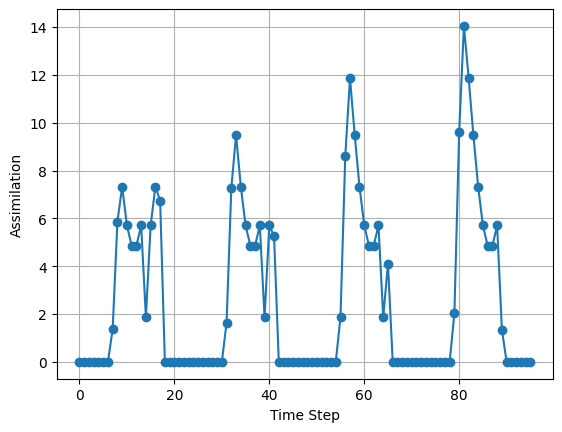

In [555]:
#@ Example Usage

driver_file = 'https://raw.githubusercontent.com/DRWang3/MPM_testing/refs/heads/main/generated_hourly_weather_data.csv'
parameter_file =  'https://raw.githubusercontent.com/DRWang3/MPM_testing/refs/heads/main/parameters.csv'
#resource_pool_file = 'https://raw.githubusercontent.com/DRWang3/MPM_testing/refs/heads/main/resource_pools_single.csv'
resource_pool_file ='https://raw.githubusercontent.com/DRWang3/MPM_testing/refs/heads/main/resource_pools_2RPs.csv'

model = model_handler(driver_file, parameter_file, resource_pool_file)
model.run_simulation()
model.plot_outputs()